<a href="https://colab.research.google.com/github/menna-ibrahim/Speech-Emption-Recognition/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Speech Emotion Recognition**
This project aims to build and train a CNN network to recognize emotion from speech. We used the CREMA dataset with more than 7000 audios labeled with 6 different labels: Happiness, Sadness, Disgust, Anger, Fear and Neutral. 

This notebook is divided into three main parts. First part is uploading the data and getting familiar with it and plotting different classes. The second part is concerned with the features extraction. We used two different categories: 1D feature space and a 2D feature space which will be discussed in detail. The third part is finally using the different feature spaces we have used to train a model and evaluate it.

## **First Part: Getting Familiar with the Dataset**

In [ ]:
import numpy as np
import os
import math
import librosa
from scipy.io import wavfile
from IPython.display import Audio
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import librosa
import soundfile as sf
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain, FrequencyMask, TimeMask, Reverse
from audiomentations import SpecCompose, SpecChannelShuffle, SpecFrequencyMask
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from librosa.feature import mfcc, delta

### **Uploading Data from Google drive**

In [ ]:
! pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link = 'https://drive.google.com/file/d/1AbYKFAug3uYx7j1w4qF9FYseKdE-fYfo/view?usp=sharing' # The shareable link
# to get the id part of the file
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Crema.zip')
! unzip Crema.zip

### **Reading Data into a list**

In [ ]:
dir_path="/content/Crema/"
directory = os.fsencode(dir_path)
audio_paths = sorted(os.listdir(directory))
dataset=[]
labels=[]
for file in audio_paths:
  filename = os.fsdecode(file)
  file_path=dir_path+filename
  file_path=os.fsencode(file_path)
  samplerate, audio = wavfile.read(file_path) #sample rate is constant no need for a list
  dataset.append(audio)
  label=filename.split("_")[-2] #splitting the filename to extract the label from it ex:SAD,ANG,..
  labels.append(label)
dict_labels={'ANG':'Anger','DIS':'Disgust','FEA':'Fear','HAP':'Happiness','NEU':'Neutral','SAD':'Sadness'}

As we were expermenting on the dataset, we have found an empty audio in the dataset and we decided to delete it from our dataset and work on 7441 audios instead of 7442

In [ ]:
del dataset[6187]
del labels[6187]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


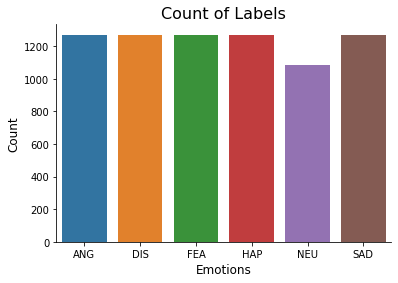

In [ ]:
import seaborn as sns
plt.title('Count of Labels', size=16)
sns.countplot(labels)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

### **Playing Audio**

In [ ]:
def play_audio(audio,label):
  print(str(dict_labels[label])+" Audio")
  return Audio(audio, rate=samplerate)

In [ ]:
def play_class_audio(label,start):
  i=labels.index(label,start)
  print(str(dict_labels[label]+" Audio"))
  return Audio(dataset[i], rate=samplerate)

In [ ]:
play_class_audio("DIS",0)

Disgust Audio


In [ ]:
play_class_audio("ANG",0)

Anger Audio


In [ ]:
play_class_audio("SAD",0)

Sadness Audio


In [ ]:
play_class_audio("FEA",0)

Fear Audio


In [ ]:
play_class_audio("HAP",0)

Happiness Audio


In [ ]:
play_class_audio("NEU",0)

Neutral Audio


### **Plotting Audio Wave**

In [ ]:
def plot_audio(start):
  for label in dict_labels.keys():
    audio_num=labels.index(label,start)
    fig=plt.figure()
    plt.plot(dataset[audio_num])
    fig.suptitle("Waveplot of "+str(dict_labels[labels[audio_num]]+" audio"))
    plt.xlabel("t")
    plt.ylabel("f(t)")
    plt.show()

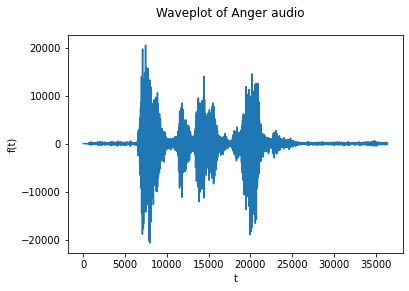

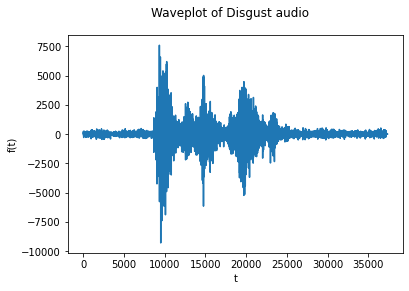

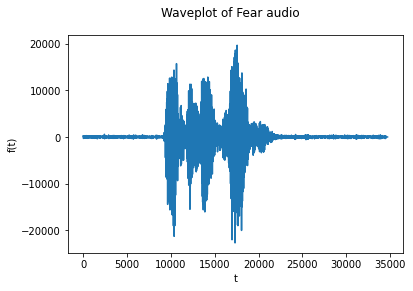

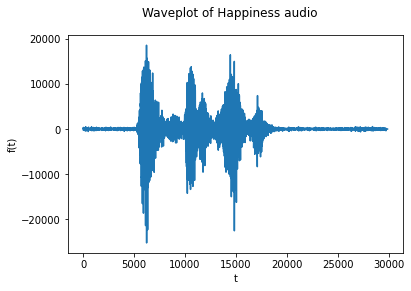

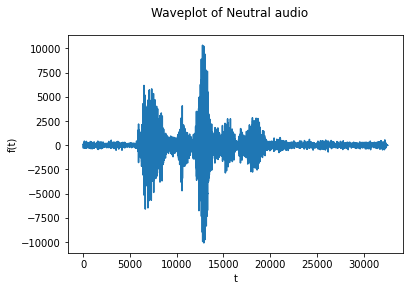

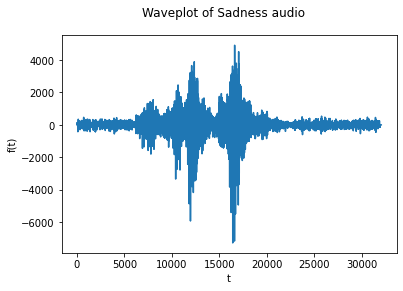

In [ ]:
plot_audio(0)

### **Splitting Data**

We split the data into 70% for training and 30% for testing. We then split the training set into 65% for training and 5% for validation which will be used for hypertuning.

In [ ]:
train_dataset,test_dataset, train_labels, test_labels=train_test_split(dataset, labels, test_size=0.3, random_state=0,stratify=labels)
train_dataset,validate_dataset,train_labels,validate_labels=train_test_split(train_dataset,train_labels, test_size=0.05, random_state=0,stratify=train_labels)

## **Second Part: Extracting Features**

### **A) 1D Feature Space**

In [ ]:
def get_average_length(dataset):
  sum=0
  for audio in dataset:
    sum+=len(audio)
  return int(sum/len(dataset))

In [ ]:
def zero_pad(audio,avg_length,token=0):
  if token:
    zeros= np.zeros(shape=(avg_length-len(audio)-1))
    zeros = np.append(zeros,-10)
  else:
    zeros= np.zeros(shape=(avg_length-len(audio)))
  audio=np.concatenate((zeros,np.array(audio)),axis=0)
  return audio

In [ ]:
def trim(audio,avg_length):
  return np.array(audio[-1*avg_length:])

In [ ]:
def normalize(audio):
  audio = audio.astype('float64')
  audio = np.subtract(audio, np.min(audio))/np.subtract(np.max(audio),np.min(audio))
  return audio

In [ ]:
def attribute_scale(data,min,max):
  data = np.array(data).astype('float64')
  dataset = np.subtract(data,min) / np.subtract(max,min)
  return dataset

In [ ]:
def prepare_mask(data_length,padding,features_list):
  mask = []
  for p in padding:
    mask_row= []
    zeros = np.zeros(shape=p)
    threes = np.ones(shape=data_length-p)*3 #audio mask = 3
    mask_row = np.concatenate((zeros,threes),axis=0)
    i=1 #zcr mask = 1, energy mask =2
    for f in features_list:
      f_mask= np.ones(shape=int(f))*i
      mask_row = np.concatenate((mask_row,f_mask),axis=0)
      i+=1
    mask.append(mask_row)
  return np.array(mask)

In [ ]:
def resize_dataset(dataset, avg_length, normalization=0,mask=0,token=0):
  padded_dataset = []
  mask_list = []
  for audio in dataset:
    audio = np.array(audio)
    original_length = audio.shape[-1]
    if normalization==1:
      audio = normalize(audio)
    if original_length < avg_length:
      audio = zero_pad(audio,avg_length,token)
      mask_list.append(avg_length-original_length)
    elif original_length > avg_length:
      audio = trim(audio,avg_length)
      mask_list.append(0)   
    else:
      mask_list.append(0)
    padded_dataset.append(audio)
  if mask==1:
    return np.array(padded_dataset), np.array(mask_list)
  return np.array(padded_dataset)

In [ ]:
def stretch_dataset(dataset, avg_length):
  stretched_dataset=[]
  for audio in dataset:
    rate = len(audio) / avg_length
    audio = librosa.effects.time_stretch(np.array(audio).astype('float64'),rate)
    stretched_dataset.append(audio)
  return np.array(stretched_dataset)

In [ ]:
#librosa zcr + dividing file into frames
def zcr_energy_librosa(dataset,f,overlap_percentage):
  zcr_energy=[]
  for audio in dataset:
    samples_no=len(audio)
    zcr=[]
    energy=[]
    overlap= math.ceil(overlap_percentage*samples_no)
    frame_length=math.ceil( samples_no/f +overlap)
    i=0
    j=0
    frame_num = 0
    while frame_num < f:
      j= i+frame_length
      frame=np.array(audio[i:j]).astype('float64')
      i=min(i+frame_length-overlap,samples_no-frame_length)
      zcr.append(sum(librosa.feature.zero_crossing_rate(frame,frame_length=len(frame))[0]))
      energy.append(frame.dot(frame)/len(frame))
      frame_num +=1
    zcr_energy_audio=np.concatenate((np.array(zcr),np.array(energy)),axis=0)
    zcr_energy.append(zcr_energy_audio)
  return np.array(zcr_energy)

In [ ]:
def concat_features_to_dataset(dataset,avg_length,train_dataset,mode='ZERO_PAD',
                               extra_features=0,attribute_scaling=0,f=1,overlap_percent=0):
  concatenated_dataset = []
  features = []
  if extra_features==1: #add zcr and energy to audio
    features = zcr_energy_librosa(dataset, f, overlap_percent)
    if attribute_scaling == 1: #attribute scale the extra features
      t_features = zcr_energy_librosa(train_dataset, f, overlap_percent)
      min = np.min(t_features,axis=0)
      max = np.max(t_features,axis=0)
      features = attribute_scale(features,min,max)
  if mode == 'ZERO_PAD': #zero padding
    dataset = resize_dataset(dataset, avg_length)
  elif mode == 'ZERO_PAD_NORMALIZED': #zero padding and normalize audio
    dataset = resize_dataset(dataset,avg_length,normalization=1)
  elif mode == 'ZERO_PAD_MASKED': # zero padding and adding mask
    dataset, padding = resize_dataset(dataset,avg_length,normalization=0,mask=1)
    features_list = np.array([f,f]).astype(int)
    mask = prepare_mask(avg_length,padding,features_list)
  elif mode == 'ZERO_PAD_NORMALIZED_MASKED': #zero padding with normalization of the audio and adding a mask
    dataset, padding = resize_dataset(dataset,avg_length,normalization=1,mask=1)
    features_list = np.array([f,f]).astype(int)
    mask = prepare_mask(avg_length,padding,features_list)
  elif mode == 'ZERO_PAD_TOKEN': #zero padding with token
    dataset = resize_dataset(dataset,avg_length,token=1)
  elif mode == 'ZERO_PAD_NORMALIZED_TOKEN': #zero padding with normalization and token
    dataset = resize_dataset(dataset,avg_length,normalization=1,token=1)
  elif mode == 'STRETCH': #stretching audio
    dataset = stretch_dataset(dataset, avg_length)
  if extra_features==1:
    concatenated_dataset= np.concatenate((dataset,features),axis=1)
  else:
    concatenated_dataset = dataset
  if mode == 'ZERO_PAD_MASKED' or mode == 'ZERO_PAD_NORMALIZED_MASKED':
    return concatenated_dataset, mask
  return concatenated_dataset

In [ ]:
def getMFCC (dataset, n_mfcc, samplerate):
  MFCC = []
  for audio in dataset:
    MFCC.append(mfcc(audio, sr=samplerate, n_mfcc=n_mfcc))
  return MFCC

In [ ]:
def weights_init(m):
    for name, layer in m.named_modules(): 
      if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):           
          torch.nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')

In [ ]:
def getDeltaMFCC (dataset, samplerate):
  deltaMFCC = []
  for audio in dataset:
    deltaMFCC.append(delta(mfcc(audio.astype(float), sr=samplerate, n_mfcc=1), width=3))
  return deltaMFCC

We have tried many approaches to try and compare between them to get an intuition of which feature space will give us the best outcome.

First we have to make sure that all our network input are the same. We first get the average length of the training length then we follow one of two methods. 

**First method** is **zero-padding/trimming** the audio, we loop over our data and if the audio is smaller than the average length, we add our zero-padding in the beginning of the audio. The reason we did that is because we believe that the end of the speech is more influential when it comes to emotion recognition. This is why we believe that it is more important to keep the end of the audio intact without manipulating it. The same thought is applied if the audio is larger than the average length, we trim the first part of the audio.

**Second method** is **stretching/compressing** the audio, we have used librosa library to stretch/compress the time of the audio to the average length of the data.

We also tried adding extra features to the audio like zero-crossing-rate and energy of the original audio before manipulating it. To make the extra features also of equal length. We divided the audio into a fixed number of frames (f) but the frames are of varying length depending on the length of the original audio. We then calculated the zcr using librosa library and calculated the energy of each frame but with normalizing it to the frame length as they vary from one audio to another and concatenated both features in a vector which will be the extra feature space vector.

We then tried to normalize the audio and apply attribute scaling on the feature vector to see if this would make learning for the model easier.

We also tried other ways to reduce the noise added from zero-padding by trying two methods. The first one is inspired from the separation token commonly used in NLP which is simply adding a unique token to separate the padding from the original data. The second method is inspired from the idea of giving the model an attention mask to focus on the audio and the extra features rather than the noise of the padding.

Lastly we prepared all of these feature spaces and saved them on a drive so that we can re-run the model using the same training set to avoid messing with the integrity of the test dataset.

MFCC and Delta MFCC are another set of features extracted proven to be useful for prominent results, the mel-frequency cepstrum is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency. Mel-frequency cepstral coefficients are coefficients that collectively make up an MFC, and the Delta MFCC is simply the derivative of the MFCC.

In [ ]:
avg_length=get_average_length(train_dataset)
f = 100
overlap_percent = 0.01

#zero pad and trimming for the audio without extra features
train_features = concat_features_to_dataset(train_dataset,avg_length,train_dataset,'ZERO_PAD')
validate_features = concat_features_to_dataset(validate_dataset,avg_length,train_dataset,'ZERO_PAD')
test_features = concat_features_to_dataset(test_dataset,avg_length,train_dataset,'ZERO_PAD')

np.save("/content/gdrive/MyDrive/Project 3/Zero Padding/Train/Data.npy", train_features)
np.save("/content/gdrive/MyDrive/Project 3/Zero Padding/Train/Labels.npy", train_labels)
np.save("/content/gdrive/MyDrive/Project 3/Zero Padding//Test/Data.npy", test_features)
np.save("/content/gdrive/MyDrive/Project 3/Zero Padding/Test/Labels.npy", test_labels)
np.save("/content/gdrive/MyDrive/Project 3/Zero Padding/Validate/Data.npy", validate_features)
np.save("/content/gdrive/MyDrive/Project 3/Zero Padding/Validate/Labels.npy", validate_labels)

#Stretching the audio without extra features
train_features = concat_features_to_dataset(train_dataset,avg_length,train_dataset,'STRETCH')
validate_features = concat_features_to_dataset(validate_dataset,avg_length,train_dataset,'STRETCH')
test_features = concat_features_to_dataset(test_dataset,avg_length,train_dataset,'STRETCH')

np.save("/content/gdrive/MyDrive/Project 3/Stretched/Train/Data.npy", train_features)
np.save("/content/gdrive/MyDrive/Project 3/Stretched/Train/Labels.npy", train_labels)
np.save("/content/gdrive/MyDrive/Project 3/Stretched//Test/Data.npy", test_features)
np.save("/content/gdrive/MyDrive/Project 3/Stretched/Test/Labels.npy", test_labels)
np.save("/content/gdrive/MyDrive/Project 3/Stretched/Validate/Data.npy", validate_features)
np.save("/content/gdrive/MyDrive/Project 3/Stretched/Validate/Labels.npy", validate_labels)

#zero pad and trimming with extra features
train_features = concat_features_to_dataset(train_dataset,avg_length,train_dataset,'ZERO_PAD',extra_features=1,attribute_scaling=0,f=f,overlap_percent=overlap_percent)
validate_features = concat_features_to_dataset(validate_dataset,avg_length,train_dataset,'ZERO_PAD',extra_features=1,attribute_scaling=0,f=f,overlap_percent=overlap_percent)
test_features = concat_features_to_dataset(test_dataset,avg_length,train_dataset,'ZERO_PAD',extra_features=1,attribute_scaling=0,f=f,overlap_percent=overlap_percent)

np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Train/Data.npy", train_features)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Train/Labels.npy", train_labels)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Test/Data.npy", test_features)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Test/Labels.npy", test_labels)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Validate/Data.npy", validate_features)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Validate/Labels.npy", validate_labels)

#zero pad and trimming with extra features and normalization
train_features = concat_features_to_dataset(train_dataset,avg_length,train_dataset,'ZERO_PAD_NORMALIZED',extra_features=1,attribute_scaling=1,f=f,overlap_percent=overlap_percent)
validate_features = concat_features_to_dataset(validate_dataset,avg_length,train_dataset,'ZERO_PAD_NORMALIZED',extra_features=1,attribute_scaling=1,f=f,overlap_percent=overlap_percent)
test_features = concat_features_to_dataset(test_dataset,avg_length,train_dataset,'ZERO_PAD_NORMALIZED',extra_features=1,attribute_scaling=1,f=f,overlap_percent=overlap_percent)

np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Train/Data.npy", train_features)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Train/Labels.npy", train_labels)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Test/Data.npy", test_features)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Test/Labels.npy", test_labels)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Validate/Data.npy", validate_features)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Validate/Labels.npy", validate_labels)


#zero pad and trimming with extra features and normalization with a token
train_features = concat_features_to_dataset(train_dataset,avg_length,train_dataset,'ZERO_PAD_NORMALIZED_TOKEN',extra_features=1,attribute_scaling=1,f=f,overlap_percent=overlap_percent)
validate_features = concat_features_to_dataset(validate_dataset,avg_length,train_dataset,'ZERO_PAD_NORMALIZED_TOKEN',extra_features=1,attribute_scaling=1,f=f,overlap_percent=overlap_percent)
test_features = concat_features_to_dataset(test_dataset,avg_length,train_dataset,'ZERO_PAD_NORMALIZED_TOKEN',extra_features=1,attribute_scaling=1,f=f,overlap_percent=overlap_percent)

np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Token/Train/Data.npy", train_features)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Token/Train/Labels.npy", train_labels)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Token/Test/Data.npy", test_features)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Token/Test/Labels.npy", test_labels)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Token/Validate/Data.npy", validate_features)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Token/Validate/Labels.npy", validate_labels)

#zero pad and trimming with extra features and normalization with a mask
train_features,train_mask = concat_features_to_dataset(train_dataset,avg_length,train_dataset,'ZERO_PAD_NORMALIZED_MASKED',extra_features=1,attribute_scaling=1,f=f,overlap_percent=overlap_percent)
validate_features, validate_mask = concat_features_to_dataset(validate_dataset,avg_length,train_dataset,'ZERO_PAD_NORMALIZED_MASKED',extra_features=1,attribute_scaling=1,f=f,overlap_percent=overlap_percent)
test_features, test_mask = concat_features_to_dataset(test_dataset,avg_length,train_dataset,'ZERO_PAD_NORMALIZED_MASKED',extra_features=1,attribute_scaling=1,f=f,overlap_percent=overlap_percent)

train_features=np.array([train_features,train_mask])
test_features=np.array([test_features,test_mask])
validate_features=np.array([validate_features,validate_mask])

np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Mask/Train/Data.npy", train_features)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Mask/Train/Labels.npy", train_labels)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Mask/Test/Data.npy", test_features)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Mask/Test/Labels.npy", test_labels)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Mask/Validate/Data.npy", validate_features)
np.save("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Mask/Validate/Labels.npy", validate_labels)

# One Dimensional MFCC with n_mfcc=1
train_features = getMFCC(stretchedTrainData, 1)
validate_features = getMFCC(stretchedValidateData, 1)
test_features = getMFCC(stretchedTestData, 1)

np.save("/content/gdrive/MyDrive/Project 3/MFCC/1D/Train/Data.npy", train_features)
np.save("/content/gdrive/MyDrive/Project 3/MFCC/1D/Train/Labels.npy", train_labels)
np.save("/content/gdrive/MyDrive/Project 3/MFCC/1D/Test/Data.npy", test_features)
np.save("/content/gdrive/MyDrive/Project 3/MFCC/1D/Test/Labels.npy", test_labels)
np.save("/content/gdrive/MyDrive/Project 3/MFCC/1D/Validation/Data.npy", validate_features)
np.save("/content/gdrive/MyDrive/Project 3/MFCC/1D/Validation/Labels.npy", validate_labels)

# One Dimensional Delta MFCC with n_mfcc=1
train_features = getDeltaMFCC(stretchedTrainData)
validate_features = getDeltaMFCC(stretchedValidateData)
test_features = getDeltaMFCC(stretchedTestData)

np.save("/content/gdrive/MyDrive/Project 3/Delta MFCC/Train/Data.npy", train_features)
np.save("/content/gdrive/MyDrive/Project 3/Delta MFCC/Train/Labels.npy", train_labels)
np.save("/content/gdrive/MyDrive/Project 3/Delta MFCC/Test/Data.npy", test_features)
np.save("/content/gdrive/MyDrive/Project 3/Delta MFCC/Test/Labels.npy", test_labels)
np.save("/content/gdrive/MyDrive/Project 3/Delta MFCC/Validation/Data.npy", validate_features)
np.save("/content/gdrive/MyDrive/Project 3/Delta MFCC/Validation/Labels.npy", validate_labels)

### **B) 2D Feature Space**

**Spectrograms**

In [ ]:
def NormalizeData(data):
  return (data - np.min(data)) / (np.max(data) - np.min(data))

In [ ]:
def Spectrograms(dataset, dimension):
  spectrograms = []
  for audio in dataset:
    y = np.array(audio, dtype=float)
    sr=samplerate
    n_fft=4096
    hop_length=math.floor(audio.shape[0]/(dimension))
    n_mels=dimension
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)
    spectrograms.append(NormalizeData(S_DB)[range(-dimension, 0)][:,range(-dimension, 0)])
  return np.array(spectrograms)

In two dimesnional convolution layers, we used 2 types of feature spaces, the Mel-Spectrogram and MFCC, the MFCC is exactly the same as mentioned in one dimensional feauture space except for the number of the coefficients returned, we used it with 13 coefficients and another with 20 and used as a two dimensional feautre space.

The Mel spectrogram is a spectrogram that is converted to a Mel scale. Then, what is the spectrogram and The Mel Scale? A spectrogram is a visualization of the frequency spectrum of a signal, where the frequency spectrum of a signal is the frequency range that is contained by the signal.

**Saving Spectrograms**

In [ ]:
trainingSpectrograms = Spectrograms(train_dataset, 256)
validatingSpectrograms = Spectrograms(validate_dataset, 256)
testingSpectrogrmas = Spectrograms(test_dataset, 256)
np.save("/content/gdrive/MyDrive/Project 3/Spectrograms/Train/Data.npy", trainingSpectrograms)
np.save("/content/gdrive/MyDrive/Project 3/Spectrograms/Train/Labels.npy", train_labels)
np.save("/content/gdrive/MyDrive/Project 3/Spectrograms/Validate/Data.npy", validatingSpectrograms)
np.save("/content/gdrive/MyDrive/Project 3/Spectrograms/Validate/Labels.npy", validate_labels)
np.save("/content/gdrive/MyDrive/Project 3/Spectrograms/Test/Data.npy", testingSpectrogrmas)
np.save("/content/gdrive/MyDrive/Project 3/Spectrograms/Test/Labels.npy", test_labels)

**MFCC**

In [ ]:
# Two Dimensional MFCC with n_mfcc=20
train_features = getMFCC(stretchedTrainData, 20)
validate_features = getMFCC(stretchedValidateData, 20)
test_features = getMFCC(stretchedTestData, 20)

np.save("/content/gdrive/MyDrive/Project 3/MFCC/2D/Train/Data.npy", train_features)
np.save("/content/gdrive/MyDrive/Project 3/MFCC/2D/Train/Labels.npy", train_labels)
np.save("/content/gdrive/MyDrive/Project 3/MFCC/2D/Test/Data.npy", test_features)
np.save("/content/gdrive/MyDrive/Project 3/MFCC/2D/Test/Labels.npy", test_labels)
np.save("/content/gdrive/MyDrive/Project 3/MFCC/2D/Validation/Data.npy", validate_features)
np.save("/content/gdrive/MyDrive/Project 3/MFCC/2D/Validation/Labels.npy", validate_labels)

## **Third Part: Building and Training the Model**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import classification_report
import numpy as np
import argparse
import time
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### **1D Models**

**Dataloader**

In [ ]:
class FeaturesDataset(Dataset):
  def __init__(self, array,labels,transform=None, target_transform=None,mask_flag=0):
    self.array = array
    self.labels = labels
    self.transform = transform
    self.target_transform = target_transform
    self.mask_flag = mask_flag
    self.dict_labels = {'ANG':0,'DIS':1,'FEA':2,'HAP':3,'NEU':4,'SAD':5}
      
  def __getitem__(self, index):
      if self.mask_flag:
        sample = self.array[:,index,:]
      else:
        sample = self.array[index]
      label = self.labels[index]
      if self.transform:
          sample = self.transform(sample)
      if self.target_transform:
          label = self.target_transform(label)
      return sample, self.dict_labels[label]

  def __len__(self):
      return len(self.labels)

**Model**

We tried to replicate Alexnet model with little modifications and it yielded in good results

In [ ]:
class OneDModel(nn.Module):
  def __init__(self, numChannels, classes, fc1_dimensions):
    super(OneDModel, self).__init__()
    self.conv1 = nn.Conv1d(in_channels=numChannels, out_channels=96,
			kernel_size=5)

    self.conv2 = nn.Conv1d(in_channels=96, out_channels=256,
			kernel_size=5)
    
    self.conv3 = nn.Conv1d(in_channels=256, out_channels=384,
			kernel_size=3)

    self.conv4 = nn.Conv1d(in_channels=384, out_channels=256,
			kernel_size=3)
    
    self.batchnorm = nn.BatchNorm1d(256)
    self.fc1 = nn.Linear(in_features=fc1_dimensions, out_features=4096)
    self.fc2 = nn.Linear(in_features=4096, out_features=4096)
    self.fc3 = nn.Linear(in_features=4096, out_features=classes)

  def forward(self, x) :
    x = F.relu(self.conv1(x))
    x = F.max_pool1d(x, kernel_size=5, stride=5)

    x = F.relu(self.conv2(x))
    x = F.max_pool1d(x, kernel_size=5, stride=5)

    x = F.dropout(x, 0.3)
    x = F.relu(self.conv3(x))
    x = F.dropout(x, 0.4)
    x = F.relu(self.conv4(x))
    x = F.max_pool1d(x, kernel_size=5, stride=5)  
    x = self.batchnorm(x)
    x = torch.flatten(x,1)

    x = F.relu(self.fc1(x))
    x = F.dropout(x, 0.5)
    x = F.relu(self.fc2(x))
    return F.log_softmax(self.fc3(x), dim=1)

In [ ]:
def tvt(optimizer, mode, model, dataloader, mfcc=0):
  if mode == 'train':
    model.train()
    numberOfBatches = trainNumOfBatches
  elif mode == 'validation':
    model.eval()
    numberOfBatches = valNumOfBatches
  else:
    model.eval()
    predictedLabels = []
  batchNumber = 1
  totalLoss = 0
  correctPred = 0
  lossFn = nn.CrossEntropyLoss()
  for (data, labels) in dataloader:
        data = data.float()
        if mfcc == 1:
          data = torch.squeeze(data, 1)
        elif mfcc == 2:
           data = data.unsqueeze_(0).permute(1, 0, 2,3)
        data = data.unsqueeze_(0).permute(1, 0, 2)
        (data, labels) = (data.to(device), labels.to(device))

        pred = model(data)
        if mode != 'test':
          loss = lossFn(pred, labels)
          totalLoss += loss
          correctPred += (pred.argmax(1) == labels).type(
            torch.float).sum().item()
        if mode == 'train':
          optimizer.zero_grad() 
          loss.backward()  
          optimizer.step()
        if mode == 'test':
          predictedLabels.extend(pred.argmax(axis=1).cpu().numpy())
          correctPred = predictedLabels

        del data
        del labels
        torch.cuda.empty_cache()
        batchNumber += 1
  return totalLoss/len(dataloader), correctPred

**1- Zero padding and trimming without extra features**

In [ ]:
train_features = np.load("/content/gdrive/MyDrive/Project 3/Zero Padding/Train/Data.npy")
train_labels = np.load("/content/gdrive/MyDrive/Project 3/Zero Padding/Train/Labels.npy")

validate_features = np.load("/content/gdrive/MyDrive/Project 3/Zero Padding/Validate/Data.npy")
validate_labels = np.load("/content/gdrive/MyDrive/Project 3/Zero Padding/Validate/Labels.npy")

test_features = np.load("/content/gdrive/MyDrive/Project 3/Zero Padding/Test/Data.npy")
test_labels = np.load("/content/gdrive/MyDrive/Project 3/Zero Padding/Test/Labels.npy")

#datasets
train_dataset = FeaturesDataset(train_features, train_labels)
validate_dataset = FeaturesDataset(validate_features, validate_labels)
test_dataset = FeaturesDataset(test_features, test_labels)

INIT_LR = 1e-5
BATCH_SIZE = 48
EPOCHS = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

trainDataLoader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(validate_dataset, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

trainNumOfBatches = len(trainDataLoader.dataset) // BATCH_SIZE
valNumOfBatches = len(valDataLoader.dataset) // BATCH_SIZE

model = OneDModel(numChannels=1, classes=6, fc1_dimensions = 82688)
#model.load_state_dict(torch.load(PATH))
model.to(device)
opt = optim.Adam(model.parameters(), lr=INIT_LR, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=0, factor=.3, threshold=1e-4,verbose=True)
print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)

with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  enumLabels = []
  for label in test_dataset.labels:
      enumLabels.append(train_dataset.dict_labels[label])
  print(classification_report(np.array(enumLabels), np.array(predections)))

cuda
Training Model
Epoch 1/20
Train loss: 1.521952, Train accuracy: 0.3725
Validation loss: 1.567217, Validation accuracy: 0.3563
Epoch 2/20
Train loss: 1.468149, Train accuracy: 0.3968
Validation loss: 1.521798, Validation accuracy: 0.3525
Epoch 3/20
Train loss: 1.461153, Train accuracy: 0.4112
Validation loss: 1.514065, Validation accuracy: 0.3716
Epoch 4/20
Train loss: 1.436510, Train accuracy: 0.4192
Validation loss: 1.490341, Validation accuracy: 0.4176
Epoch 5/20
Train loss: 1.439862, Train accuracy: 0.4192
Validation loss: 1.511999, Validation accuracy: 0.3755
Epoch 00005: reducing learning rate of group 0 to 3.0000e-06.
Epoch 6/20
Train loss: 1.372114, Train accuracy: 0.4403
Validation loss: 1.533957, Validation accuracy: 0.3755
Epoch 00006: reducing learning rate of group 0 to 9.0000e-07.
Epoch 7/20
Train loss: 1.369032, Train accuracy: 0.4514
Validation loss: 1.466075, Validation accuracy: 0.3793
Epoch 8/20
Train loss: 1.345205, Train accuracy: 0.4601
Validation loss: 1.4681

**2. Stretching audio without extra features**

In [ ]:
train_features = np.load("/content/gdrive/MyDrive/Project 3/Stretched/Train/Data.npy")
train_labels = np.load("/content/gdrive/MyDrive/Project 3/Stretched/Train/Labels.npy")

validate_features = np.load("/content/gdrive/MyDrive/Project 3/Stretched/Validate/Data.npy")
validate_labels = np.load("/content/gdrive/MyDrive/Project 3/Stretched/Validate/Labels.npy")

test_features = np.load("/content/gdrive/MyDrive/Project 3/Stretched/Test/Data.npy")
test_labels = np.load("/content/gdrive/MyDrive/Project 3/Stretched/Test/Labels.npy")

#datasets
train_dataset = FeaturesDataset(train_features, train_labels)
validate_dataset = FeaturesDataset(validate_features, validate_labels)
test_dataset = FeaturesDataset(test_features, test_labels)

INIT_LR = 1e-5
BATCH_SIZE = 48
EPOCHS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

trainDataLoader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(validate_dataset, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

trainNumOfBatches = len(trainDataLoader.dataset) // BATCH_SIZE
valNumOfBatches = len(valDataLoader.dataset) // BATCH_SIZE

model = OneDModel(numChannels=1, classes=6,fc1_dimensions=82944)
#model.load_state_dict(torch.load(PATH))
model.to(device)
opt = optim.Adam(model.parameters(), lr=INIT_LR, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=0, factor=.3, threshold=1e-4,verbose=True)
print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)

with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  enumLabels = []
  for label in test_dataset.labels:
      enumLabels.append(train_dataset.dict_labels[label])
  print(classification_report(np.array(enumLabels), np.array(predections)))

Training Model
Epoch 1/10
Train loss: 1.518690, Train accuracy: 0.3699
Validation loss: 1.530194, Validation accuracy: 0.3716
Epoch 2/10
Train loss: 1.507464, Train accuracy: 0.3806
Validation loss: 1.515976, Validation accuracy: 0.4061
Epoch 3/10
Train loss: 1.468990, Train accuracy: 0.3978
Validation loss: 1.504318, Validation accuracy: 0.3525
Epoch 4/10
Train loss: 1.473371, Train accuracy: 0.3893
Validation loss: 1.504215, Validation accuracy: 0.3487
Epoch 00004: reducing learning rate of group 0 to 3.0000e-06.
Epoch 5/10
Train loss: 1.400198, Train accuracy: 0.4271
Validation loss: 1.475309, Validation accuracy: 0.4100
Epoch 6/10
Train loss: 1.399397, Train accuracy: 0.4239
Validation loss: 1.492771, Validation accuracy: 0.3716
Epoch 00006: reducing learning rate of group 0 to 9.0000e-07.
Epoch 7/10
Train loss: 1.372562, Train accuracy: 0.4340
Validation loss: 1.485402, Validation accuracy: 0.3870
Epoch 00007: reducing learning rate of group 0 to 2.7000e-07.
Epoch 8/10
Train loss:

**3- Zero padding and trimming with extra features**

In [ ]:
train_features = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Train/Data.npy")
train_labels = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Train/Labels.npy")

validate_features = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Validate/Data.npy")
validate_labels = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Validate/Labels.npy")

test_features = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Test/Data.npy")
test_labels = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Test/Labels.npy")

#datasets
train_dataset = FeaturesDataset(train_features, train_labels)
validate_dataset = FeaturesDataset(validate_features, validate_labels)
test_dataset = FeaturesDataset(test_features, test_labels)

INIT_LR = 1e-5
BATCH_SIZE = 48
EPOCHS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

trainDataLoader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(validate_dataset, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

trainNumOfBatches = len(trainDataLoader.dataset) // BATCH_SIZE
valNumOfBatches = len(valDataLoader.dataset) // BATCH_SIZE

model = OneDModel(numChannels=1, classes=6, fc1_dimensions = 83200)
#model.load_state_dict(torch.load(PATH))
model.to(device)
opt = optim.Adam(model.parameters(), lr=INIT_LR, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=0, factor=.3, threshold=1e-4,verbose=True)
print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)

with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  enumLabels = []
  for label in test_dataset.labels:
      enumLabels.append(train_dataset.dict_labels[label])
  print(classification_report(np.array(enumLabels), np.array(predections)))

cuda
Training Model
Epoch 1/10
Train loss: 1.632020, Train accuracy: 0.3226
Validation loss: 1.648383, Validation accuracy: 0.3142
Epoch 2/10
Train loss: 1.562432, Train accuracy: 0.3412
Validation loss: 1.626178, Validation accuracy: 0.3218
Epoch 3/10
Train loss: 1.536905, Train accuracy: 0.3600
Validation loss: 1.604166, Validation accuracy: 0.3525
Epoch 4/10
Train loss: 1.513425, Train accuracy: 0.3774
Validation loss: 1.583295, Validation accuracy: 0.3448
Epoch 5/10
Train loss: 1.526296, Train accuracy: 0.3756
Validation loss: 1.549180, Validation accuracy: 0.3640
Epoch 6/10
Train loss: 1.512354, Train accuracy: 0.3897
Validation loss: 1.567532, Validation accuracy: 0.3563
Epoch 00006: reducing learning rate of group 0 to 3.0000e-06.
Epoch 7/10
Train loss: 1.493702, Train accuracy: 0.3958
Validation loss: 1.539372, Validation accuracy: 0.3640
Epoch 8/10
Train loss: 1.476655, Train accuracy: 0.3920
Validation loss: 1.604540, Validation accuracy: 0.3678
Epoch 00008: reducing learning

**4- Zero padding and trimming with extra features and normalization**

In [ ]:
train_features = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Train/Data.npy")
train_labels = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Train/Labels.npy")

validate_features = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Validate/Data.npy")
validate_labels = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Validate/Labels.npy")

test_features = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Test/Data.npy")
test_labels = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Test/Labels.npy")

#datasets
train_dataset = FeaturesDataset(train_features, train_labels)
validate_dataset = FeaturesDataset(validate_features, validate_labels)
test_dataset = FeaturesDataset(test_features, test_labels)

INIT_LR = 1e-5
BATCH_SIZE = 48
EPOCHS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

trainDataLoader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(validate_dataset, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

trainNumOfBatches = len(trainDataLoader.dataset) // BATCH_SIZE
valNumOfBatches = len(valDataLoader.dataset) // BATCH_SIZE

model = OneDModel(numChannels=1, classes=6, fc1_dimensions = 83200)
#model.load_state_dict(torch.load(PATH))
model.to(device)
opt = optim.Adam(model.parameters(), lr=INIT_LR, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=0, factor=.3, threshold=1e-4,verbose=True)
print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)

with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  enumLabels = []
  for label in test_dataset.labels:
      enumLabels.append(train_dataset.dict_labels[label])
  print(classification_report(np.array(enumLabels), np.array(predections)))

cuda
Training Model
Epoch 1/10
Train loss: 1.758172, Train accuracy: 0.2272
Validation loss: 1.724534, Validation accuracy: 0.2529
Epoch 2/10
Train loss: 1.715647, Train accuracy: 0.2802
Validation loss: 1.685206, Validation accuracy: 0.2950
Epoch 3/10
Train loss: 1.680464, Train accuracy: 0.3002
Validation loss: 1.678182, Validation accuracy: 0.3180
Epoch 4/10
Train loss: 1.637961, Train accuracy: 0.3309
Validation loss: 1.640537, Validation accuracy: 0.3142
Epoch 5/10
Train loss: 1.589024, Train accuracy: 0.3471
Validation loss: 1.599628, Validation accuracy: 0.3218
Epoch 6/10
Train loss: 1.534446, Train accuracy: 0.3804
Validation loss: 1.547375, Validation accuracy: 0.3870
Epoch 7/10
Train loss: 1.495014, Train accuracy: 0.3950
Validation loss: 1.571783, Validation accuracy: 0.3793
Epoch 00007: reducing learning rate of group 0 to 3.0000e-06.
Epoch 8/10
Train loss: 1.451990, Train accuracy: 0.4130
Validation loss: 1.539763, Validation accuracy: 0.3563
Epoch 9/10
Train loss: 1.43973

**5- Zero padding and trimming with extra features and normalization with the addition of token**

In [ ]:
train_features = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Token/Train/Data.npy")
train_labels = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Token/Train/Labels.npy")

validate_features = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Token/Validate/Data.npy")
validate_labels = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Token/Validate/Labels.npy")

test_features = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Token/Test/Data.npy")
test_labels = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Token/Test/Labels.npy")

#datasets
train_dataset = FeaturesDataset(train_features, train_labels)
validate_dataset = FeaturesDataset(validate_features, validate_labels)
test_dataset = FeaturesDataset(test_features, test_labels)

INIT_LR = 1e-5
BATCH_SIZE = 32
EPOCHS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

trainDataLoader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(validate_dataset, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

trainNumOfBatches = len(trainDataLoader.dataset) // BATCH_SIZE
valNumOfBatches = len(valDataLoader.dataset) // BATCH_SIZE

model = OneDModel(numChannels=1, classes=6, fc1_dimension=82944)
#model.load_state_dict(torch.load(PATH))
model.to(device)
opt = optim.Adam(model.parameters(), lr=INIT_LR, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=.3, threshold=1e-4)
print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  # scheduler.step()

with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  enumLabels = []
  for label in test_dataset.labels:
      enumLabels.append(train_dataset.dict_labels[label])
  print(classification_report(np.array(enumLabels), np.array(predections)))

Training Model
Epoch 1/10
Train loss: 1.763108, Train accuracy: 0.2349
Validation loss: 1.760314, Validation accuracy: 0.2299
Epoch 2/10
Train loss: 1.722329, Train accuracy: 0.2662
Validation loss: 1.745694, Validation accuracy: 0.2835
Epoch 3/10
Train loss: 1.688920, Train accuracy: 0.2931
Validation loss: 1.728810, Validation accuracy: 0.2605
Epoch 4/10
Train loss: 1.652464, Train accuracy: 0.3216
Validation loss: 1.686234, Validation accuracy: 0.3103
Epoch 5/10
Train loss: 1.585254, Train accuracy: 0.3525
Validation loss: 1.583777, Validation accuracy: 0.3525
Epoch 6/10
Train loss: 1.507278, Train accuracy: 0.3891
Validation loss: 1.592790, Validation accuracy: 0.3257
Epoch 7/10
Train loss: 1.454677, Train accuracy: 0.4112
Validation loss: 1.563323, Validation accuracy: 0.3755
Epoch 8/10
Train loss: 1.412294, Train accuracy: 0.4269
Validation loss: 1.952340, Validation accuracy: 0.2950
Epoch 9/10
Train loss: 1.383032, Train accuracy: 0.4465
Validation loss: 1.568314, Validation acc

**6. Zero padding and trimming with extra features and normalization along with a mask channel**

We have faced some problems with the limited space with this feature space. We are not able to display the details of the epochs for these reasons. However, it is worth mentioning that we tried it on a different device and the result after 20 epochs using a batch size of 32 was 36% accuracy. The model was not overfitting. However, due to its excessive need for memory, we decided to ditch as the validation accuracy was worse than other feature spaces.

In [ ]:
train_features = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Mask/Train/Data.npy") #needs to be changed to another local address on colab
train_labels = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Mask/Train/Labels.npy")

validate_features = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Mask/Normalized/Validate/Data.npy")
validate_labels = np.load("/content/gdrive/MyDrive/Project  3/ZCR_Energy/Normalized/Mask/Validate/Labels.npy")

test_features = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Mask/Test/Data.npy")
test_labels = np.load("/content/gdrive/MyDrive/Project 3/ZCR_Energy/Normalized/Mask/Test/Labels.npy")

#datasets
train_dataset = FeaturesDataset(train_features, train_labels,transform=ToTensor(),mask_flag=1)
validate_=dataset = FeaturesDataset(validate_features, validate_labels,transform=ToTensor(),mask_flag=1)
test_dataset = FeaturesDataset(test_features, test_labels,transform=ToTensor(),mask_flag=1)


INIT_LR = 1e-5
BATCH_SIZE = 32
EPOCHS = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

trainDataLoader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(validate_dataset, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

trainNumOfBatches = len(trainDataLoader.dataset) // BATCH_SIZE
valNumOfBatches = len(valDataLoader.dataset) // BATCH_SIZE

model = OneDModel(numChannels=2, classes=6, fc1_dimensions = 82944)
#model.load_state_dict(torch.load(PATH))
model.to(device)
opt = optim.Adam(model.parameters(), lr=INIT_LR, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=0, factor=.3, threshold=1e-4,verbose=True)
print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)

with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  enumLabels = []
  for label in test_dataset.labels:
      enumLabels.append(train_dataset.dict_labels[label])
  print(classification_report(np.array(enumLabels), np.array(predections)))

**7. Mel Frequency Cepstral Coefficients (MFCC) of Stretched Audio**

In [ ]:
train_features = np.load("/content/gdrive/MyDrive/Project 3/MFCC/1D/Train/Data.npy")
train_labels = np.load("/content/gdrive/MyDrive/Project 3/MFCC/1D/Train/Labels.npy")
validation_features = np.load("/content/gdrive/MyDrive/Project 3/MFCC/1D/Validation/Data.npy")
validate_labels = np.load("/content/gdrive/MyDrive/Project 3/MFCC/1D/Validation/Labels.npy")
test_features = np.load("/content/gdrive/MyDrive/Project 3/MFCC/1D/Test/Data.npy")
test_labels = np.load("/content/gdrive/MyDrive/Project 3/MFCC/1D/Test/Labels.npy")

training_data = FeaturesDataset(train_features, train_labels)
validating_data = FeaturesDataset(validation_features, validate_labels)
testing_data = FeaturesDataset(test_features, test_labels)

INIT_LR = 1e-5
BATCH_SIZE = 64
EPOCHS = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainDataLoader = DataLoader(training_data, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(validating_data, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testing_data, batch_size=BATCH_SIZE)

trainNumOfBatches = len(trainDataLoader.dataset) // BATCH_SIZE
valNumOfBatches = len(valDataLoader.dataset) // BATCH_SIZE

model = OneDModel(numChannels=1, classes=6, fc1_dimensions=1536)
# model.apply(weights_init)

model.to(device)
opt = Adam(model.parameters(), lr=INIT_LR, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=0, factor=.1, threshold=1e-4, verbose=True)
print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader, 1)
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader, 1)
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)

with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader, 1)
  enumLabels = []
  for label in testing_data.labels:
      enumLabels.append(training_data.dict_labels[label])
print(classification_report(np.array(enumLabels), np.array(predections)))

Training Model
Epoch 1/20
Train loss: 1.754098, Train accuracy: 0.2412
Validation loss: 1.743025, Validation accuracy: 0.2605
Epoch 2/20
Train loss: 1.675661, Train accuracy: 0.3224
Validation loss: 1.679778, Validation accuracy: 0.3065
Epoch 3/20
Train loss: 1.599662, Train accuracy: 0.3457
Validation loss: 1.610365, Validation accuracy: 0.3448
Epoch 4/20
Train loss: 1.549439, Train accuracy: 0.3519
Validation loss: 1.553335, Validation accuracy: 0.3448
Epoch 5/20
Train loss: 1.527005, Train accuracy: 0.3628
Validation loss: 1.558506, Validation accuracy: 0.3640
Epoch 00005: reducing learning rate of group 0 to 1.0000e-06.
Epoch 6/20
Train loss: 1.513897, Train accuracy: 0.3620
Validation loss: 1.540863, Validation accuracy: 0.3410
Epoch 7/20
Train loss: 1.511345, Train accuracy: 0.3602
Validation loss: 1.526313, Validation accuracy: 0.3295
Epoch 8/20
Train loss: 1.507677, Train accuracy: 0.3665
Validation loss: 1.519485, Validation accuracy: 0.3563
Epoch 9/20
Train loss: 1.507607, Tr

**8. Delta MFCC on Stretched Audio**

In [ ]:
train_features = np.load("/content/gdrive/MyDrive/Project 3/Delta MFCC/Train/Data.npy")
train_labels = np.load("/content/gdrive/MyDrive/Project 3/Delta MFCC/Train/Labels.npy")
validation_features = np.load("/content/gdrive/MyDrive/Project 3/Delta MFCC/Validation/Data.npy")
validate_labels = np.load("/content/gdrive/MyDrive/Project 3/Delta MFCC/Validation/Labels.npy")
test_features = np.load("/content/gdrive/MyDrive/Project 3/Delta MFCC/Test/Data.npy")
test_labels = np.load("/content/gdrive/MyDrive/Project 3/Delta MFCC/Test/Labels.npy")

training_data = FeaturesDataset(train_features, train_labels)
validating_data = FeaturesDataset(validation_features, validate_labels)
testing_data = FeaturesDataset(test_features, test_labels)

INIT_LR = 1e-5
BATCH_SIZE = 64
EPOCHS = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainDataLoader = DataLoader(training_data, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(validating_data, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testing_data, batch_size=BATCH_SIZE)

trainNumOfBatches = len(trainDataLoader.dataset) // BATCH_SIZE
valNumOfBatches = len(valDataLoader.dataset) // BATCH_SIZE

model = OneDModel(numChannels=1, classes=6, fc1_dimensions=1536)
# model.apply(weights_init)

model.to(device)
opt = Adam(model.parameters(), lr=INIT_LR, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=0, factor=.1, threshold=1e-4, verbose=True)
print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader, 1)
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader, 1)
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)

with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader, 1)
  enumLabels = []
  for label in testing_data.labels:
      enumLabels.append(training_data.dict_labels[label])
print(classification_report(np.array(enumLabels), np.array(predections)))

Training Model
Epoch 1/20
Train loss: 1.691473, Train accuracy: 0.3014
Validation loss: 1.668444, Validation accuracy: 0.2682
Epoch 2/20
Train loss: 1.591322, Train accuracy: 0.3422
Validation loss: 1.598695, Validation accuracy: 0.3333
Epoch 3/20
Train loss: 1.555255, Train accuracy: 0.3677
Validation loss: 1.579274, Validation accuracy: 0.3333
Epoch 4/20
Train loss: 1.532439, Train accuracy: 0.3707
Validation loss: 1.541642, Validation accuracy: 0.3640
Epoch 5/20
Train loss: 1.520339, Train accuracy: 0.3829
Validation loss: 1.530633, Validation accuracy: 0.3487
Epoch 6/20
Train loss: 1.508026, Train accuracy: 0.3911
Validation loss: 1.516001, Validation accuracy: 0.3602
Epoch 7/20
Train loss: 1.495471, Train accuracy: 0.3928
Validation loss: 1.501008, Validation accuracy: 0.3678
Epoch 8/20
Train loss: 1.478030, Train accuracy: 0.4015
Validation loss: 1.496722, Validation accuracy: 0.3525
Epoch 9/20
Train loss: 1.468458, Train accuracy: 0.4057
Validation loss: 1.469933, Validation acc

### **2D Models**

It was proven that two dimensional convolution models addressed with 2D feature spaces produce considerably better results than one dimensional models.

**Dataset Class**

In [ ]:
class SpectrogramsDataset(Dataset):
    def __init__(self, spectrograms, labels, transform=None, target_transform=None, train=False):
        self.labels = labels
        self.train = train
        self.spectrograms = spectrograms
        self.transform = transform
        self.target_transform = target_transform
        self.dict_labels = {'ANG':0,'DIS':1,'FEA':2,'HAP':3,'NEU':4,'SAD':5}

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        spectrogram = self.spectrograms[index]
        if self.train:
          spectrogram = augmentSpectrogram(spectrogram)
        label = self.labels[index]
        if self.transform:
            spectrogram = self.transform(spectrogram)
        if self.target_transform:
            label = self.target_transform(label)
        return spectrogram, self.dict_labels[label]

Model

In [ ]:
class TwoDModel(nn.Module):
  
  def __init__(self, numChannels, classes, fc1_dimensions):
    super(TwoDModel, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=96, kernel_size=(5, 5))
    self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5, 5))
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3, 3))
    self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3, 3))
    self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3))
    self.batchnorm = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(in_features=fc1_dimensions, out_features=4096)
    self.fc2 = nn.Linear(in_features=4096, out_features=4096)
    self.fc3 = nn.Linear(in_features=4096, out_features=classes)

  def forward(self, x) :
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, kernel_size=(3, 3), stride=(3, 3))
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, kernel_size=(3, 3), stride=(3, 3))
    x = F.dropout(x, 0.3)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.dropout(x, 0.4)
    x = F.relu(self.conv5(x))
    x = F.max_pool2d(x, kernel_size=(3, 3), stride=(3, 3))  
    x = self.batchnorm(x)
    x = flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return F.log_softmax(self.fc3(x), dim=1)

In [ ]:
class ModifiedTwoDModel(nn.Module):
  def __init__(self, numChannels, classes, fc1_dimensions):
    super(TwoDModel, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=96, kernel_size=(3, 3))
    self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(3, 3))    
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3, 3))
    self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3, 3))
    self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3))
    self.batchnorm = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(in_features=fc1_dimensions, out_features=4096)
    self.fc2 = nn.Linear(in_features=4096, out_features=4096)
    self.fc3 = nn.Linear(in_features=4096, out_features=classes)

  def forward(self, x) :
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.dropout(x, 0.3)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.dropout(x, 0.4)
    x = F.relu(self.conv5(x))
    x = F.max_pool2d(x, kernel_size=(3, 3), stride=(3, 3))  
    x = self.batchnorm(x)
    x = flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return F.log_softmax(self.fc3(x), dim=1)

In [ ]:
class SecondModifiedTwoDModel(nn.Module):
  
  def __init__(self, numChannels, classes, fc1_dimensions):
    super(SecondModifiedTwoDModel, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=96, kernel_size=(5, 5))
    self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5, 5))
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3, 3))
    self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3, 3))
    self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3))
    self.batchnorm = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(in_features=fc1_dimensions, out_features=4096)
    self.fc2 = nn.Linear(in_features=4096, out_features=4096)
    self.fc3 = nn.Linear(in_features=4096, out_features=classes)

  def forward(self, x) :
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, kernel_size=(3, 3), stride=(3, 3))
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, kernel_size=(3, 3), stride=(3, 3))
    x = F.dropout(x, 0.3)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.dropout(x, 0.4)
    x = F.relu(self.conv5(x))
    x = F.max_pool2d(x, kernel_size=(3, 3), stride=(3, 3))  
    x = self.batchnorm(x)
    x = flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return F.log_softmax(self.fc3(x), dim=1)

**Data Augmentation**

Data Augmentation is used to help model learn real patterns and reduce ovefitting, this is done by introducing transforms over the data randomly with random amounts so that the model recognize the main identifing features and not to be concerned or affected by different biases, this could be done over raw audio dataset or directly over the spectrogram

In [ ]:
augmentAudio = Compose([AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
                        TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
                        PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
                        Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
                        Gain(),
                        FrequencyMask(),
                        TimeMask(),
                        Reverse()])

In [ ]:
augmentSpectrogram = SpecCompose([SpecFrequencyMask(p=0.5)])

**1. Spectrograms**

In [ ]:
trainingSpectrograms = np.load("/content/gdrive/MyDrive/Project 3/Spectrograms/Train/Data.npy")
train_labels = np.load("/content/gdrive/MyDrive/Project 3/Spectrograms/Train/Labels.npy")
validatingSpectrograms = np.load("/content/gdrive/MyDrive/Project 3/Spectrograms/Validate/Data.npy")
validate_labels = np.load("/content/gdrive/MyDrive/Project 3/Spectrograms/Validate/Labels.npy")
testingSpectrogrmas = np.load("/content/gdrive/MyDrive/Project 3/Spectrograms/Test/Data.npy")
test_labels = np.load("/content/gdrive/MyDrive/Project 3/Spectrograms/Test/Labels.npy")

training_data = SpectrogramsDataset(trainingSpectrograms, train_labels, transform=ToTensor())
validating_data = SpectrogramsDataset(validatingSpectrograms, validate_labels, transform=ToTensor())
testing_data = SpectrogramsDataset(testingSpectrogrmas, test_labels, transform=ToTensor())

INIT_LR = 1e-5
BATCH_SIZE = 128
EPOCHS = 22

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainDataLoader = DataLoader(training_data, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(validating_data, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testing_data, batch_size=BATCH_SIZE)

trainNumOfBatches = len(trainDataLoader.dataset) // BATCH_SIZE
valNumOfBatches = len(valDataLoader.dataset) // BATCH_SIZE


model = TwoDModel(numChannels=1, classes=6)
model.to(device)
opt = Adam(model.parameters(), lr=INIT_LR, weight_decay=0.025)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=2, factor=.3, threshold=1e-1)
trainLoss = []
validationLoss = []
trainAcc = []
validationAcc = []
print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  trainLoss.append(avgTrainLoss.item()*100)
  trainAcc.append(correctPred/len(trainDataLoader.dataset))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    validationLoss.append(avgValLoss.item()*100)
    validationAcc.append(correctPred/len(valDataLoader.dataset))
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)

Plotting(trainLoss,trainAcc, validationLoss, validationAcc)

Training Model
Epoch 1/22
Train loss: 1.680983, Train accuracy: 0.3121
Validation loss: 1.766143, Validation accuracy: 0.2759
Epoch 2/22
Train loss: 1.561626, Train accuracy: 0.3588
Validation loss: 1.588365, Validation accuracy: 0.3295
Epoch 3/22
Train loss: 1.528258, Train accuracy: 0.3669
Validation loss: 1.564752, Validation accuracy: 0.3372
Epoch 4/22
Train loss: 1.492478, Train accuracy: 0.3889
Validation loss: 1.515205, Validation accuracy: 0.3755
Epoch 5/22
Train loss: 1.459807, Train accuracy: 0.4079
Validation loss: 1.433194, Validation accuracy: 0.3793
Epoch 6/22
Train loss: 1.426161, Train accuracy: 0.4294
Validation loss: 1.415450, Validation accuracy: 0.3946
Epoch 7/22
Train loss: 1.413109, Train accuracy: 0.4281
Validation loss: 1.401147, Validation accuracy: 0.3870
Epoch 8/22
Train loss: 1.403247, Train accuracy: 0.4340
Validation loss: 1.400466, Validation accuracy: 0.4061
Epoch 9/22
Train loss: 1.397970, Train accuracy: 0.4395
Validation loss: 1.371962, Validation acc

In [ ]:
with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  enumLabels = []
  for label in testing_data.labels:
      enumLabels.append(training_data.dict_labels[label])
  confusionMatrix = confusion_matrix(np.array(enumLabels), np.array(predections))
  print(classification_report(np.array(enumLabels), np.array(predections)))


Testing:
              precision    recall  f1-score   support

           0       0.71      0.74      0.72       382
           1       0.57      0.56      0.57       382
           2       0.50      0.52      0.51       381
           3       0.60      0.57      0.59       381
           4       0.68      0.61      0.65       326
           5       0.54      0.58      0.56       381

    accuracy                           0.60      2233
   macro avg       0.60      0.60      0.60      2233
weighted avg       0.60      0.60      0.60      2233



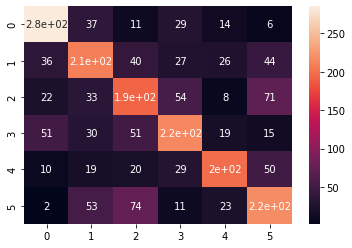

In [ ]:
df = pd.DataFrame(confusionMatrix)
sns.heatmap(df, annot=True)

Plotting Spectrogram

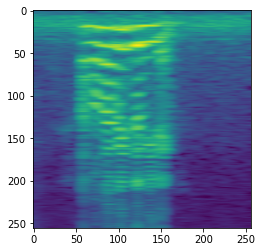

In [ ]:
plt.imshow(validatingSpectrograms[4])

**2. Mel Frequency Cepstral Coefficients (MFCC) of Stretched Audio (n_mfcc=20)**

In [ ]:
train_features = np.load("/content/gdrive/MyDrive/Project 3/MFCC/2D/Train/Data.npy")
train_labels = np.load("/content/gdrive/MyDrive/Project 3/MFCC/2D/Train/Labels.npy")
validation_features = np.load("/content/gdrive/MyDrive/Project 3/MFCC/2D/Validation/Data.npy")
validate_labels = np.load("/content/gdrive/MyDrive/Project 3/MFCC/2D/Validation/Labels.npy")
test_features = np.load("/content/gdrive/MyDrive/Project 3/MFCC/2D/Test/Data.npy")
test_labels = np.load("/content/gdrive/MyDrive/Project 3/MFCC/2D/Test/Labels.npy")

training_data = FeaturesDataset(train_features, train_labels)
validating_data = FeaturesDataset(validation_features, validate_labels)
testing_data = FeaturesDataset(test_features, test_labels)

INIT_LR = 1e-5
BATCH_SIZE = 128
EPOCHS = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainDataLoader = DataLoader(training_data, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(validating_data, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testing_data, batch_size=BATCH_SIZE)

trainNumOfBatches = len(trainDataLoader.dataset) // BATCH_SIZE
valNumOfBatches = len(valDataLoader.dataset) // BATCH_SIZE

model = ModifiedTwoDModel(numChannels=1, classes=6, fc1_dimensions=17664)
# model.apply(weights_init)

model.to(device)
opt = Adam(model.parameters(), lr=INIT_LR, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=0, factor=.1, threshold=1e-4, verbose=True)
print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader, 2)
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader, 2)
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)

with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader, 2)
  enumLabels = []
  for label in testing_data.labels:
      enumLabels.append(training_data.dict_labels[label])
print(classification_report(np.array(enumLabels), np.array(predections)))

Training Model
Epoch 1/20
Train loss: 1.606378, Train accuracy: 0.3259
Validation loss: 1.556000, Validation accuracy: 0.3793
Epoch 2/20
Train loss: 1.472600, Train accuracy: 0.3909
Validation loss: 1.517417, Validation accuracy: 0.3755
Epoch 3/20
Train loss: 1.403044, Train accuracy: 0.4273
Validation loss: 1.453078, Validation accuracy: 0.4368
Epoch 4/20
Train loss: 1.355605, Train accuracy: 0.4544
Validation loss: 1.392868, Validation accuracy: 0.4406
Epoch 5/20
Train loss: 1.323173, Train accuracy: 0.4690
Validation loss: 1.364667, Validation accuracy: 0.4559
Epoch 6/20
Train loss: 1.301846, Train accuracy: 0.4781
Validation loss: 1.377374, Validation accuracy: 0.4368
Epoch 00006: reducing learning rate of group 0 to 1.0000e-06.
Epoch 7/20
Train loss: 1.278542, Train accuracy: 0.4853
Validation loss: 1.370612, Validation accuracy: 0.4444
Epoch 00007: reducing learning rate of group 0 to 1.0000e-07.
Epoch 8/20
Train loss: 1.267723, Train accuracy: 0.5017
Validation loss: 1.376730, V

**2.1 Mel Frequency Cepstral Coefficients (MFCC) of Stretched Audio (n_mfcc=13)**

In [ ]:
PATH = '/content/gdrive/MyDrive/Project 3/Models/SecondModel2d_MFCC_Stretched.pt'
model = ModifiedTwoDModel(numChannels=1, classes=6, fc1_dimensions=17664)
model.load_state_dict(torch.load(PATH))
model.to(device)

In [ ]:
with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  enumLabels = []
  for label in testing_data.labels:
      enumLabels.append(training_data.dict_labels[label])
  print(classification_report(np.array(enumLabels), np.array(predections)))


Testing:
              precision    recall  f1-score   support

           0       0.63      0.76      0.69       382
           1       0.50      0.29      0.36       382
           2       0.56      0.25      0.34       381
           3       0.46      0.46      0.46       381
           4       0.44      0.62      0.51       326
           5       0.50      0.70      0.58       381

    accuracy                           0.51      2233
   macro avg       0.51      0.51      0.49      2233
weighted avg       0.52      0.51      0.49      2233



**2.1.1 Mel Frequency Cepstral Coefficients (MFCC) of Stretched Audio (n_mfcc=13, 20 Epochs)**

In [ ]:
PATH = '/content/gdrive/MyDrive/Project 3/Models/SecondModel2d_MFCC_Stretched_20Epoch.pt'
model = ModifiedTwoDModel(numChannels=1, classes=6, fc1_dimensions=17664)
model.load_state_dict(torch.load(PATH))
model.to(device)

In [ ]:
with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  enumLabels = []
  for label in testing_data.labels:
      enumLabels.append(training_data.dict_labels[label])
  print(classification_report(np.array(enumLabels), np.array(predections)))


Testing:
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       382
           1       0.50      0.45      0.47       382
           2       0.53      0.43      0.48       381
           3       0.52      0.54      0.53       381
           4       0.53      0.59      0.56       326
           5       0.50      0.66      0.57       381

    accuracy                           0.55      2233
   macro avg       0.56      0.55      0.55      2233
weighted avg       0.56      0.55      0.55      2233



**3. Spectrogram with Data Augmentation**

In [ ]:
trainingSpectrograms = np.load("/content/gdrive/MyDrive/Project 3/Spectrograms/Train/Data.npy")
train_labels = np.load("/content/gdrive/MyDrive/Project 3/Spectrograms/Train/Labels.npy")
validatingSpectrograms = np.load("/content/gdrive/MyDrive/Project 3/Spectrograms/Validate/Data.npy")
validate_labels = np.load("/content/gdrive/MyDrive/Project 3/Spectrograms/Validate/Labels.npy")
testingSpectrogrmas = np.load("/content/gdrive/MyDrive/Project 3/Spectrograms/Test/Data.npy")
test_labels = np.load("/content/gdrive/MyDrive/Project 3/Spectrograms/Test/Labels.npy")

training_data = SpectrogramsDataset(trainingSpectrograms, train_labels, transform=ToTensor(),train=True)
validating_data = SpectrogramsDataset(validatingSpectrograms, validate_labels, transform=ToTensor())
testing_data = SpectrogramsDataset(testingSpectrogrmas, test_labels, transform=ToTensor())

INIT_LR = 1e-5
BATCH_SIZE = 100
EPOCHS = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainDataLoader = DataLoader(training_data, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(validating_data, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testing_data, batch_size=BATCH_SIZE)

trainNumOfBatches = len(trainDataLoader.dataset) // BATCH_SIZE
valNumOfBatches = len(valDataLoader.dataset) // BATCH_SIZE


model = SecondModifiedTwoDModel(numChannels=1, classes=6)
# model.load_state_dict(torch.load(PATH))
model.to(device)
opt = Adam(model.parameters(), lr=INIT_LR, weight_decay=0.025)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=2, factor=.3, threshold=1e-4)
print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred = tvt(opt, 'train', model, trainDataLoader)
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  with torch.no_grad():
    avgValLoss, correctPred = tvt(opt, 'validation', model, valDataLoader)
    print("Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avgValLoss, correctPred/len(valDataLoader.dataset)))
  scheduler.step(avgValLoss)

with torch.no_grad():
  print('\nTesting:')
  _, predections = tvt(opt, 'test', model, testDataLoader)
  enumLabels = []
  for label in testing_data.labels:
      enumLabels.append(training_data.dict_labels[label])
  print(classification_report(np.array(enumLabels), np.array(predections)))

Training Model
Epoch 1/100
Train loss: 1.690329, Train accuracy: 0.2844
Validation loss: 1.749818, Validation accuracy: 0.2874
Epoch 2/100
Train loss: 1.559831, Train accuracy: 0.3531
Validation loss: 1.564681, Validation accuracy: 0.3487
Epoch 3/100
Train loss: 1.518660, Train accuracy: 0.3723
Validation loss: 1.540700, Validation accuracy: 0.3640
Epoch 4/100
Train loss: 1.488767, Train accuracy: 0.3863
Validation loss: 1.513611, Validation accuracy: 0.3908
Epoch 5/100
Train loss: 1.466313, Train accuracy: 0.3972
Validation loss: 1.494172, Validation accuracy: 0.3908
Epoch 6/100
Train loss: 1.432764, Train accuracy: 0.4178
Validation loss: 1.472830, Validation accuracy: 0.3946
Epoch 7/100
Train loss: 1.416144, Train accuracy: 0.4257
Validation loss: 1.636806, Validation accuracy: 0.3793
Epoch 8/100
Train loss: 1.400209, Train accuracy: 0.4322
Validation loss: 1.459467, Validation accuracy: 0.4215
Epoch 9/100
Train loss: 1.377100, Train accuracy: 0.4423
Validation loss: 1.447988, Valid